In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os

import seaborn as sns

import imageio

# add the top level directory to allow it to be imported
import sys
sys.path.append(os.path.split(os.getcwd())[0])
from utilities import plotting_utilities
from utilities import helper_functions

import xarray as xr
from scipy import stats

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
window_size=1.5 # number of seconds before/after each stimulus event over which to integrate activity for the purpose of calling a cell 'responsive'
significance_level = 0.05 # level at which to declare a response 'significant'

In [3]:
data_path = os.path.join(os.path.split(os.getcwd())[0],'data')
session_list = pd.read_csv(os.path.join(os.path.join(data_path,'session_list.csv')))
active_sessions = session_list.query('session_type == "active"')
active_sessions

,mouse_id,sex,genotype,AP_coord,ML_coord,DV_coord,session_type,recording_date,processing_date
18,M332849,M,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,1.5,3.125,2.5,active,2018-06-14 12:44:33.658000,2018-07-26 12:11:01.983524799-07:00
19,M348126,F,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai94(TITL-...,1.5,2.625,2.5,active,2018-06-13 13:47:38.463000,2018-07-26 18:15:45.828682184-07:00
20,M351181,F,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai94(TITL-...,1.5,2.625,2.5,active,2018-03-14 14:32:15.328000,2018-07-26 18:59:36.293976068-07:00
21,M397408,F,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,1.5,2.625,2.5,active,2018-11-01 11:40:14.487000,2019-01-22 01:32:10.700291872-08:00


In [4]:
session = {}
for idx,row in active_sessions.reset_index().iterrows():
    session[row['mouse_id']] = helper_functions.load_session(row['mouse_id'], session_type='active')
    print('on session {} of {}   '.format(idx+1,len(active_sessions)),end='\r')

## build out responsiveness summary

In [5]:
figure_3_folder = os.path.join(os.path.split(os.getcwd())[0], 'figure_4')
responsiveness_summary_all = pd.read_csv(os.path.join(figure_3_folder, 'active_responsiveness_summary.csv'))
for mouse_id in session.keys():
    session[mouse_id].responsiveness_summary = responsiveness_summary_all.query('mouse_id == @mouse_id').copy()

In [6]:
def make_cell_map(session, ax=None):
    if ax is None:
        fig,ax=plt.subplots()

    cells_to_show = session.filtered_cell_ids

    # create an empty RGB image to add the cell images to
    rows, cols = np.shape(session.cell_images[session.filtered_cell_ids[0]])
    all_cells_image = np.zeros((rows, cols, 3))

    for cell_id in cells_to_show:
        cell_img = session.cell_images[cell_id]
        cell_img /= cell_img.max()
        cell_img[cell_img > 0.5] = 1
        cell_img[cell_img <= 0.5] = 0

        this_cell = session.responsiveness_summary.query('cell_id == @cell_id and condition == "hit"').iloc[0]

        if this_cell['direction_of_effect_on_means'] > 0 and this_cell['p-value_on_means'] <= significance_level:
            # make cell red by filling only R channel
            all_cells_image[:, :, 0] += cell_img
        elif this_cell['direction_of_effect_on_means'] < 0 and this_cell['p-value_on_means'] <= significance_level:
            # make cell blue by filling only B channel
            all_cells_image[:, :, 2] += cell_img
        else:
            # make cell white by filling all channels equally
            for channel in range(3):
                all_cells_image[:, :, channel] += cell_img
                
    # clip at 0 and 1
    all_cells_image[np.where(all_cells_image > 1)] = 1
    all_cells_image[np.where(all_cells_image < 0)] = 0
    ax.imshow(all_cells_image)    
    ax.axis('off')
    
    return all_cells_image

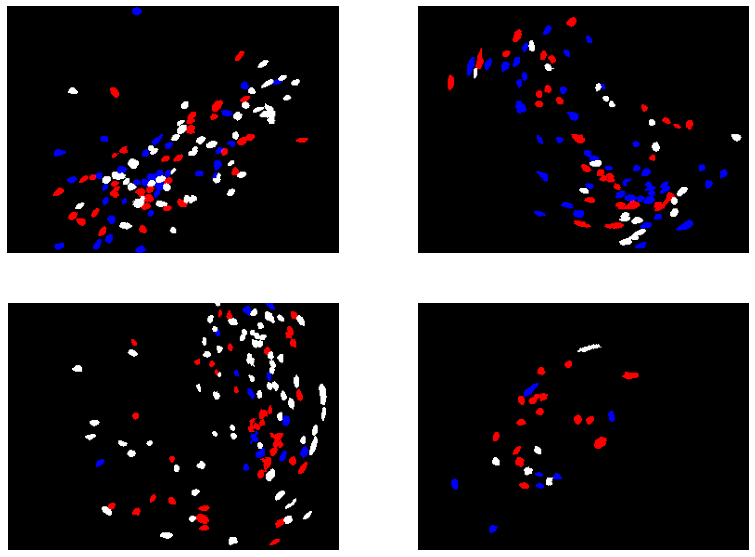

In [7]:
def show_all_FOVs(ax = None):
    if ax is None:
        fig,ax=plt.subplots(2,2,figsize=(13.5,10))
    
    # cast axes to list to allow us to flatten
    if isinstance(ax, list):
        ax = np.array(ax)
    for ii, mouse_id in enumerate(session.keys()):
        all_cells_image = make_cell_map(session[mouse_id], ax.flatten()[ii])
        ax.flatten()[ii].axis('off')
        
show_all_FOVs()

In [8]:
def get_distance(session, cell_0, cell_1):
    x0 = session.metrics.loc[cell_0]['overallCenterInPixelsX']
    y0 = session.metrics.loc[cell_0]['overallCenterInPixelsY']

    x1 = session.metrics.loc[cell_1]['overallCenterInPixelsX']
    y1 = session.metrics.loc[cell_1]['overallCenterInPixelsY']

    return np.sqrt((x1 - x0)**2 + (y1 - y0)**2)

In [9]:
dfs = []
for mouse_id in session.keys():
    distances = xr.DataArray(
        np.zeros((len(session[mouse_id].filtered_cell_ids), len(session[mouse_id].filtered_cell_ids))),
        dims=('cell_0','cell_1'),
        coords={'cell_0': session[mouse_id].filtered_cell_ids, 'cell_1': session[mouse_id].filtered_cell_ids}
    )*np.nan

    both_significant = xr.DataArray(
        np.zeros((len(session[mouse_id].filtered_cell_ids), len(session[mouse_id].filtered_cell_ids))),
        dims=('cell_0','cell_1'),
        coords={'cell_0': session[mouse_id].filtered_cell_ids, 'cell_1': session[mouse_id].filtered_cell_ids}
    )*np.nan

    same_direction = xr.DataArray(
        np.zeros((len(session[mouse_id].filtered_cell_ids), len(session[mouse_id].filtered_cell_ids))),
        dims=('cell_0','cell_1'),
        coords={'cell_0': session[mouse_id].filtered_cell_ids, 'cell_1': session[mouse_id].filtered_cell_ids}
    )*np.nan

    direction = xr.DataArray(
        np.zeros((len(session[mouse_id].filtered_cell_ids), len(session[mouse_id].filtered_cell_ids))),
        dims=('cell_0','cell_1'),
        coords={'cell_0': session[mouse_id].filtered_cell_ids, 'cell_1': session[mouse_id].filtered_cell_ids}
    )*np.nan

    for row,cell_0 in enumerate(session[mouse_id].filtered_cell_ids):
        print(cell_0, end='\r')
        for col,cell_1 in enumerate(session[mouse_id].filtered_cell_ids):
            if row > col:
                distances.loc[dict(cell_0 = cell_0, cell_1 = cell_1)] = get_distance(session[mouse_id], cell_0, cell_1)

                c0_rs = session[mouse_id].responsiveness_summary.query('cell_id == @cell_0 and condition == "hit"').iloc[0]
                c1_rs = session[mouse_id].responsiveness_summary.query('cell_id == @cell_1 and condition == "hit"').iloc[0]
                both_significant.loc[dict(cell_0 = cell_0, cell_1 = cell_1)] = c0_rs['p-value_on_means'] <= significance_level and c1_rs['p-value_on_means'] <= significance_level
                same_direction.loc[dict(cell_0 = cell_0, cell_1 = cell_1)] = c0_rs['direction_of_effect_on_means'] == c1_rs['direction_of_effect_on_means'] 
                if c0_rs['direction_of_effect_on_means'] == c1_rs['direction_of_effect_on_means']:
                    direction.loc[dict(cell_0 = cell_0, cell_1 = cell_1)] = c0_rs['direction_of_effect_on_means'] 


    list_of_dicts = []
    # build out a dataframe of values where both cells have significant responses
    locs = np.where(both_significant == 1)
    for x,y in zip(locs[0], locs[1]):
        list_of_dicts.append({
            'cell_0':str(both_significant[x,y].coords['cell_0'].values),
            'cell_1':str(both_significant[x,y].coords['cell_1'].values),
            'distance':float(distances[x,y].values),
            'same_direction':bool(same_direction[x,y].values),
            'direction':float(direction[x,y].values),
        })
    df = pd.DataFrame(list_of_dicts)
    dfs.append(df)
    print(stats.ttest_ind(df.query('same_direction == True')['distance'], df.query('same_direction == False')['distance']))
    
distance_df = pd.concat(dfs)    

Ttest_indResult(statistic=0.5993691155174907, pvalue=0.5489799309596226)
Ttest_indResult(statistic=0.6053573328831919, pvalue=0.5449885741457791)
Ttest_indResult(statistic=2.148329996049898, pvalue=0.03187575204456136)
Ttest_indResult(statistic=-3.9040014073388654, pvalue=0.00012163897389841356)


In [10]:
distance_df

,cell_0,cell_1,distance,same_direction,direction
0,C005,C000,28.442925,True,-1.0
1,C006,C000,145.413204,False,NaN
2,C006,C005,118.726577,False,NaN
3,C012,C000,59.396970,True,-1.0
4,C012,C005,49.040799,True,-1.0
...,...,...,...,...,...
248,C165,C023,122.016392,False,NaN
249,C165,C024,95.047357,False,NaN
250,C165,C103,95.084173,False,NaN
251,C165,C115,21.023796,True,-1.0


In [11]:
distances.shape

(28, 28)

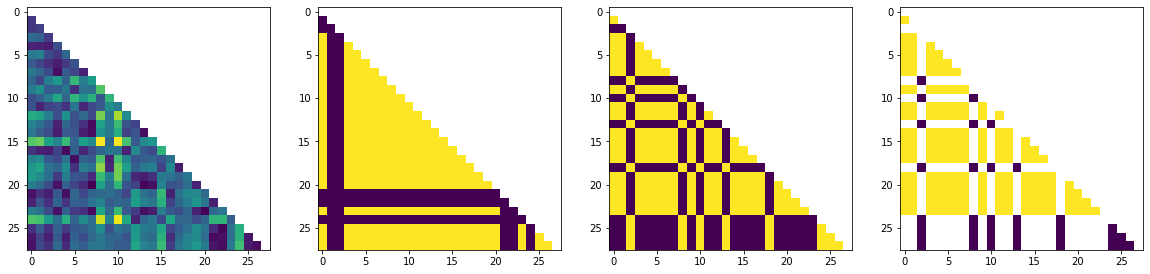

In [12]:
fig,ax=plt.subplots(1,4,figsize=(20,5))
ax[0].imshow(distances.values)
ax[1].imshow(both_significant.values)
ax[2].imshow(same_direction.values)
ax[3].imshow(direction.values)

In [13]:
print(stats.ttest_ind(distance_df.query('same_direction == True')['distance'], distance_df.query('same_direction == False')['distance']))

Ttest_indResult(statistic=1.604796880069648, pvalue=0.10858357210100096)


In [14]:
print(stats.mannwhitneyu(distance_df.query('same_direction == True')['distance'], distance_df.query('same_direction == False')['distance'], alternative='less'))

MannwhitneyuResult(statistic=6284181.0, pvalue=0.9670335953829322)


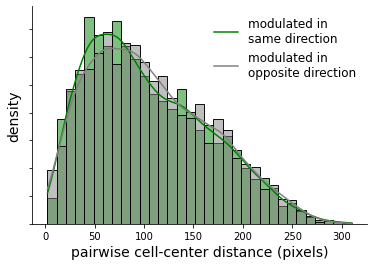

In [15]:
def distance_density_plot(ax=None):
    if ax is None:
        fig,ax=plt.subplots()
    sns.histplot(
        data=distance_df, 
        x="distance", 
        hue='same_direction',
        hue_order=[True,False],
        kde=True,
        stat='density',
        common_norm=False,
        palette=['gray','green'],
        ax=ax,
    )
    ax.legend(['modulated in\nsame direction','modulated in\nopposite direction'], fontsize=12, frameon=False)
    ax.set_xlabel('pairwise cell-center distance (pixels)',fontsize=14)
    ax.set_ylabel('density',fontsize=14)
    ax.set_yticklabels([])
    sns.despine()
distance_density_plot()

## horizontal figure

# vertical figure

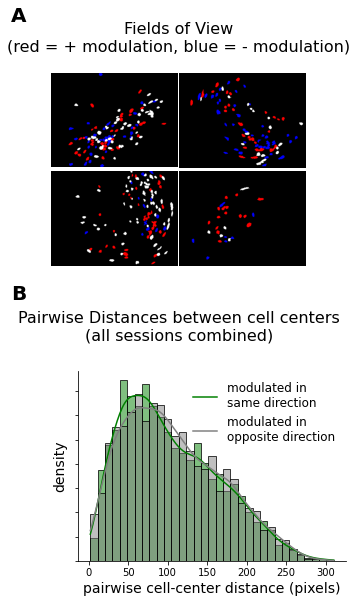

In [16]:
save_fig = True

figsize=(6,10)
figure = plt.figure(figsize=figsize)
axes = {
    'A':plotting_utilities.placeAxesOnGrid(figure, xspan=[0.12,0.88], yspan=[0.1,0.46], dim=[2,2], hspace=0.01, wspace=0.01),
    'B':plotting_utilities.placeAxesOnGrid(figure, xspan=[0.2,1], yspan=[0.65, 1]),
}

sample_mouse_id = list(session.keys())[0]
all_cells_image = show_all_FOVs(ax=axes['A'])
distance_density_plot(ax=axes['B'])

# add labels
labels = [
    {'label_text':'A', 'xpos':0.0,   'ypos':0.00},
    {'label_text':'B', 'xpos':0.0, 'ypos':0.51},
]
for label in labels:
    plotting_utilities.add_label(
        figure,
        label_text = label['label_text'],
        xpos = label['xpos'],
        ypos = label['ypos'],
        fontsize=20,
        weight="bold"
    )
    
# add titles
titles = [
    {'title_text':'Fields of View\n(red = + modulation, blue = - modulation)', 'xpos':0.5,   'ypos':0.0},
    {'title_text':'Pairwise Distances between cell centers\n(all sessions combined)', 'xpos':0.5, 'ypos':0.53},
]
for title in titles:
    plotting_utilities.add_label(
        figure,
        label_text = title['title_text'],
        xpos = title['xpos'],
        ypos = title['ypos'],
        fontsize=16,
        ha='center',
        va='top'
    )

if save_fig:
    plotting_utilities.save_figure(figure, fname='figure_5', formats=['.png','.pdf'], size=figsize, dpi=500)

## quantify cell counts for the sample ROI shown in A

In [17]:
len(session[sample_mouse_id].responsiveness_summary['cell_id'].unique())

116

In [18]:
df = session[sample_mouse_id].responsiveness_summary
positively_driven_cells = df[
    (df['condition']=='hit')
    &(df['direction_of_effect_on_means']>0)
    &(df['p-value_on_means']<=significance_level)
]
len(positively_driven_cells['cell_id'].unique())

38

In [19]:
df = session[sample_mouse_id].responsiveness_summary
negatively_driven_cells = df[
    (df['condition']=='hit')
    &(df['direction_of_effect_on_means']<0)
    &(df['p-value_on_means']<=significance_level)
]
len(negatively_driven_cells['cell_id'].unique())

34

In [20]:
df = session[sample_mouse_id].responsiveness_summary
undriven_cells = df[
    (df['condition']=='hit')
    &(df['p-value_on_means']>significance_level)
]
len(undriven_cells['cell_id'].unique())

44